In [17]:
# Datasets:
# curl -0  https://www.thedatum.org/datasets/TSB-AD-M.zip
import numpy as np
import pandas as pd

In [18]:
from SAE_LSTM import SAE_LSTM

In [19]:
from datasets import read_dataset_semisupervised

X_train, y_train, X_test, y_test = [], [], [], []
for key, value in read_dataset_semisupervised("MSL").items():
    X_train.append(value[0])
    y_train.append(value[1])
    X_test.append(value[2])
    y_test.append(value[3])

X_train = np.concatenate(X_train, axis=0)
y_train = np.concatenate(y_train, axis=0)
X_test = np.concatenate(X_test, axis=0)
y_test = np.concatenate(y_test, axis=0)
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)
print("Anomalies in test set:", np.sum(y_test))

016_MSL_id_15_Sensor_tr_500_1st_780.csv
005_MSL_id_4_Sensor_tr_855_1st_2700.csv
013_MSL_id_12_Sensor_tr_554_1st_1200.csv
017_MSL_id_16_Sensor_tr_512_1st_1850.csv
009_MSL_id_8_Sensor_tr_714_1st_1390.csv
015_MSL_id_14_Sensor_tr_575_1st_1250.csv
012_MSL_id_11_Sensor_tr_539_1st_940.csv
006_MSL_id_5_Sensor_tr_1150_1st_1250.csv
004_MSL_id_3_Sensor_tr_530_1st_630.csv
011_MSL_id_10_Sensor_tr_1525_1st_4590.csv
014_MSL_id_13_Sensor_tr_1525_1st_4575.csv
003_MSL_id_2_Sensor_tr_883_1st_1238.csv
010_MSL_id_9_Sensor_tr_554_1st_1172.csv
002_MSL_id_1_Sensor_tr_500_1st_900.csv
007_MSL_id_6_Sensor_tr_980_1st_3550.csv
008_MSL_id_7_Sensor_tr_656_1st_1630.csv
Train shape: (28100, 50, 55)
Test shape: (19458, 50, 55)
Anomalies in test set: 98424.0


In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS device")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA device")
else:
    device = torch.device("cpu")
    print("Using CPU device")

Using MPS device


In [21]:
from utils import create_sequences, go_back_to_original_shape

In [22]:
from sklearn.metrics import classification_report


train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=32, shuffle=False
)

# sequences_val = create_sequences(X_val, seq_len, step=1)
# val_dataset = TensorDataset(torch.Tensor(sequences_val))
# val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

test_dataset = TensorDataset(torch.Tensor(X_test))
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model = SAE_LSTM(
    seq_len=50, n_features=X_train.shape[2], hidden_size=64, num_layers=1
).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [23]:
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
import pytorch_lightning as pl
from loss_history import LossHistory

early_stopping_callback = EarlyStopping(
    monitor="train_loss",
    patience=5,
    mode="min",  # change to "val_loss" if using validation
)

loss_history_callback = LossHistory()

trainer = pl.Trainer(
    max_epochs=50,
    callbacks=[early_stopping_callback, loss_history_callback],
    accelerator="auto",
)
trainer.fit(model, train_dataloader)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/btempka/Studia/AE-Comp/.venv/lib/python3.14/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name    | Type   | Params | Mode  | FLOPs
---------------------------------------------------
0 | encoder | LSTM   | 31.0 K | train | 0    
1 | decoder | LSTM   | 31.0 K | train | 0    
2 | relu    | ReLU   | 0      | train | 0    
3 | fc      | Linear | 3.6 K  | train | 0    
---------------------------------------------------
65.5 K    Trainable params
0         Non-trainable params
65.5 K    Total params
0.262     Total estimated model params size (MB)
4         Modules in train mode
0         Module

Epoch 8: 100%|██████████| 879/879 [00:11<00:00, 74.61it/s, v_num=21]


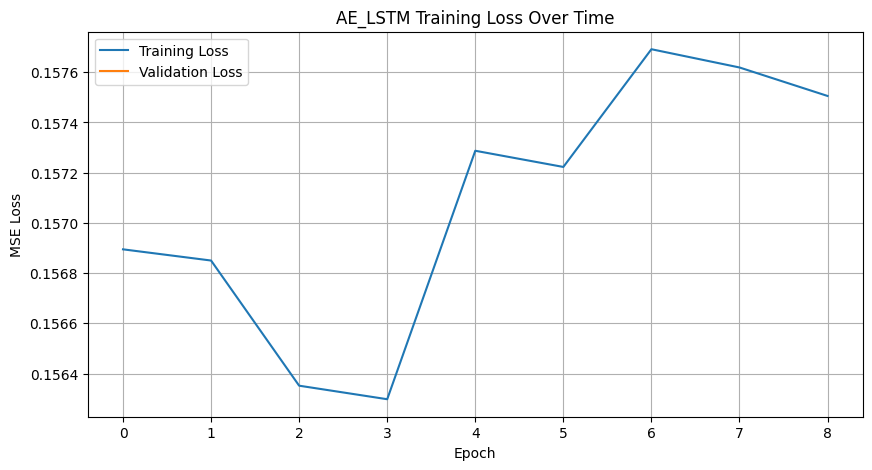

In [24]:
# Plot training loss
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(loss_history_callback.train_losses, label="Training Loss")
plt.plot(loss_history_callback.val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("AE_LSTM Training Loss Over Time")
plt.legend()
plt.grid(True)
plt.show()

In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

model.to(device)
model.eval()

with torch.no_grad():
    all_rec_errors = []
    # all_binary_preds = []

    # Process test data in batches
    for batch in test_dataloader:
        batch_data = batch[0].to(device)
        reconstructed_batch = model(batch_data)

        rec_error = ((batch_data - reconstructed_batch) ** 2).mean(dim=2, keepdim=True)
        # Convert to numpy for further processing
        rec_error_np = rec_error.cpu().numpy()
        # binary_predictions = (rec_error_np > self.threshold).astype(int)

        all_rec_errors.append(rec_error_np)
    # all_binary_preds.append(binary_predictions)

    # Concatenate results from all batches
    all_rec_errors = np.concatenate(all_rec_errors, axis=0)
    # all_binary_preds = np.concatenate(all_binary_preds, axis=0)
    # all_binary_preds = self.go_back_to_original_shape(all_binary_preds, len(data), self.seq_step)
    all_rec_errors = go_back_to_original_shape(
        all_rec_errors, X_test.shape[0], seq_step=1
    )
    roc_auc = roc_auc_score(y_test, all_rec_errors)

roc_auc

aggregated_preds.shape (19458, 1)
aggregated_preds.shape (19458, 1)


0.5628223407641955